In [15]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from control.matlab import *
import control 

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [16]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# simulate the ERA system by using control package
sysERA = ss(Ar,Br,Cr,Dr,1)
y = np.zeros((time.shape[0],p,q))
for qi in range(q):
    y[:,:,qi],t = impulse(sysERA,np.arange(time.shape[0]),input=qi)

Text(0.5, 1.0, 'third mass')

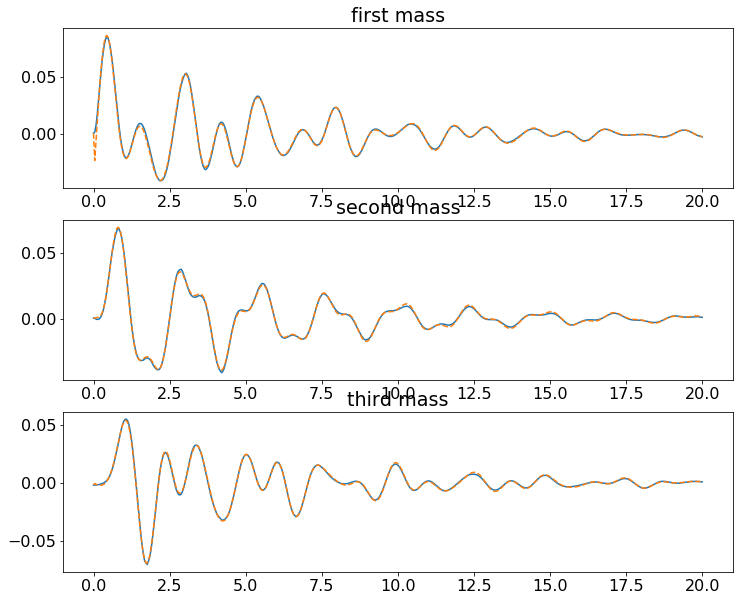

In [17]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y[:,0,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y[:,1,0], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y[:,2,0], '--')
ax3.set_title('third mass')

In [18]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

In [19]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [20]:
## MPC initialization and casadi objective function ##

Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [21]:
Q[2,2] = 0
S[2,2] = 0

In [22]:
# delta_u changing rate per step constraints
lb_u = -3*np.ones((nu,1))
ub_u = 3*np.ones((nu,1))

_lbg = -3*np.ones((nu,1))
_ubg = 3*np.ones((nu,1))

In [23]:
## create optimization problem ##
def casadi_setting_seq(nx,nu): # reference_signal
    
    #X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("delta_U",N*nu,1)
    xt = SX.sym("xt",nx,1)
    reference_signal = SX.sym("r",N,ny)
    
    J = 0
    
    lb_X = [] # lower bound for xt.
    ub_X = [] # upper bound for xt
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    x_step = xt # init step
    for k in range(N):
        # 01 
        #x_k = X[k*nx:(k+1)*nx,:]
        #x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        delta_u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])
        # 02

        # 03 next state
        
        # 03

        # 04
        g.append(x_step[10:] + delta_u_k)
        lb_g.append(_lbg)
        ub_g.append(_ubg)
        # 04
        x_step = system(x_step,delta_u_k)
        # 05

        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05
    #lb_X.append(lb_x)
    #ub_X.append(ub_x)
    x_terminal = x_step
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])
    #lb_X.append(lb_x)
    #ub_X.append(ub_x)
    return lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,reference_signal

In [24]:
#X = SX.sym("X",(N+1)*nx,1)
delta_U = SX.sym("delta_U",N*nu,1)
xt = SX.sym("xt",nx,1)
reference_signal = SX.sym("r",N,ny)
    
J = 0
    
lb_X = [] # lower bound for xt.
ub_X = [] # upper bound for xt
lb_U = [] # lower bound for delta_U
ub_U = [] # upper bound for delta_U
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g
    
x_step = xt # init step
k = 0
delta_u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])
        # 02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

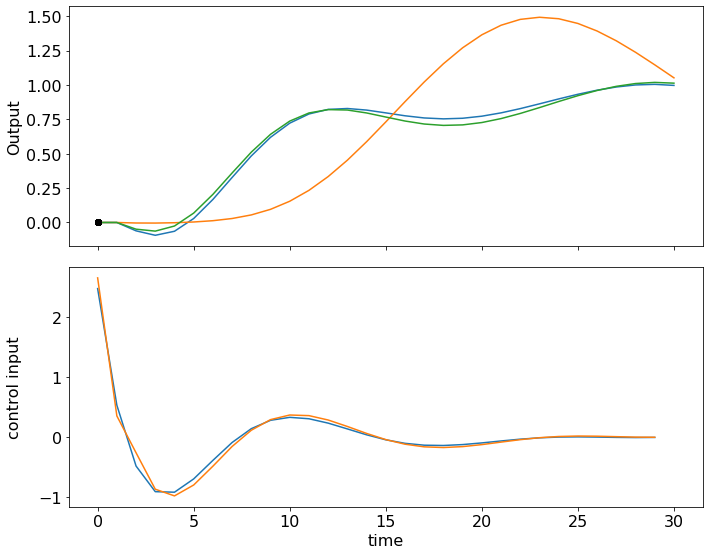

In [25]:
## test the functional solver production ##
reference = np.ones((N,ny))

lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
# Casadi solver
x_0 = np.zeros((nx,1))
lb_X.append(x_0)
ub_X.append(x_0)

lbx = vertcat(*lb_X,*lb_U)
ubx = vertcat(*lb_X,*ub_U)
x = vertcat(xt,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)
#reference = vertcat(*reference)
param = vertcat(param)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

#X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

x_test = np.zeros((nx,1))

for n in range(N):
    Y = np.hstack((Y,Cb@x_test))
    x_test = Ab@x_test + Bb@(delta_U[n]).reshape(2,1)
# visulization of the result   

fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

In [26]:
N_sim = 500 # total simulation step
time = np.linspace(1,20,num = N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))
#REFERENCE[:,150:] = 2
#REFERENCE[:,400:] = 1
#REFERENCE[0,:] = np.array(np.sin(np.linspace(-3*np.pi, 3*np.pi, N_sim+N-1))).T
#REFERENCE[1,:] = np.array(np.sin(np.linspace(-3*np.pi+2*np.pi/3, 3*np.pi+2*np.pi/3, N_sim+N-1))).T
#REFERENCE[2,:] = np.array(np.sin(np.linspace(-3*np.pi+2*2*np.pi/3, 3*np.pi+2*2*np.pi/3, N_sim+N-1))).T
#################################### reference change test

In [27]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
#u_0 = np.zeros((nu,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])



for i in range(N_sim-1):
    ############## create casadi solver
    reference = REFERENCE[:,i:i+N].T
    lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
    
    
    # Casadi solver
    lb_X.append(x_0)
    ub_X.append(x_0)
    
    lbx = vertcat(*lb_X,*lb_U)
    ubx = vertcat(*lb_X,*ub_U)
    x = vertcat(xt,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)
    
    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)

    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    ###############
    
    _xt = res['x'][:nx].full()
    
    del_U = res['x'][nx:].full().reshape(N, nu)
    del_u = (del_U[0,:]).reshape(nu,1)
    
    res_delta_u.append(del_u)
    u_st = (_xt[10:]+del_u).reshape(nu,1)
    
    #u_0 = ((xt[Ar.shape[0]:]).reshape(nu,1)+del_u).reshape(nu,1)
    
    res_u.append(u_st)
    
    #x_next = Ab@x_0 + Bb@del_u # test on model
    
    # update the x_next
    # simulate the original system
    sys.simulate(time[i:i+2], (u_st).reshape(1,nu))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (del_u).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    #x_next = system(x_0,del_u)
    
    assert np.max(x_next[10:nx]) < 6 or np.min(x_next[10:nx]) > -4
    
    res_x.append(x_next)
    
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

   6 2.1616835e+002 0.00e+000 6.97e-003  -2.5 9.56e-001    -  7.44e-001 1.00e+000f  1
   7 2.1599163e+002 0.00e+000 3.00e-003  -3.8 4.92e-001    -  8.66e-001 1.00e+000f  1
   8 2.1598094e+002 0.00e+000 6.89e-014  -3.8 1.50e-001    -  1.00e+000 1.00e+000f  1
   9 2.1598083e+002 0.00e+000 2.62e-014  -5.7 6.43e-003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1598083e+002 0.00e+000 4.12e-014  -8.6 1.65e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.0488194020783345e+001   2.1598083249301175e+002
Dual infeasibility......:  4.1245601719297261e-014   8.4936066002940680e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  7.8710364923952057e-009   1.6208634306742376e-007
Overall NLP error.......:  7.8710364923952057e-009   1.6208634306742376e-007




This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.0640183e+002 0.00e+000 7.13e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.1740280e+001 0.00e+000 1.04e-001  -1.0 6.18e-001    -  7

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.2826768e+001 0.00e+000 8.79e+000  -1.0 0.00e+000    -  0.00e+00

   4 1.5674108e+001 0.00e+000 2.95e-014  -3.8 1.77e-001    -  1.00e+000 1.00e+000f  1
   5 1.5674029e+001 0.00e+000 1.28e-013  -5.7 1.68e-002    -  1.00e+000 1.00e+000f  1
   6 1.5674029e+001 0.00e+000 2.43e-013  -8.6 1.65e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.6671534353667159e+000   1.5674028754248559e+001
Dual infeasibility......:  2.4297672341685625e-013   1.0385232624083156e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.2316322110453078e-009   1.3812538005793784e-008
Overall NLP error.......:  3.2316322110453078e-009   1.3812538005793784e-008


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constra

   5 8.4742668e+000 0.00e+000 1.09e-014  -5.7 1.24e-002    -  1.00e+000 1.00e+000f  1
   6 8.4742668e+000 0.00e+000 8.62e-015  -8.6 1.09e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5867942880571309e+000   8.4742668246393826e+000
Dual infeasibility......:  8.6162804524436935e-015   4.6015201932276880e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7702824169520141e-009   1.4794679157562625e-008
Overall NLP error.......:  2.7702824169520141e-009   1.4794679157562625e-008


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   2 3.3532108e+000 0.00e+000 1.63e-003  -1.7 9.72e-002    -  9.94e-001 1.00e+000f  1
   3 3.3450790e+000 0.00e+000 1.26e-013  -2.5 1.64e-001    -  1.00e+000 1.00e+000f  1
   4 3.3450554e+000 0.00e+000 1.21e-013  -3.8 7.83e-003    -  1.00e+000 1.00e+000f  1
   5 3.3450551e+000 0.00e+000 8.68e-014  -5.7 9.25e-004    -  1.00e+000 1.00e+000f  1
   6 3.3450551e+000 0.00e+000 2.99e-013  -8.6 1.08e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.2127698422618436e+000   3.3450550719860881e+000
Dual infeasibility......:  2.9925772464957792e-013   4.5238937667681369e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5171325365470471e-009   3.8051616564112365e-009
Overall NLP error.......:  2.5171325365470471e-009   3.8051616564112365e-009


Number of objective function evaluations             = 7
Number of objective gradi

   1 2.7699681e+000 0.00e+000 5.70e-002  -1.0 4.15e-001    -  8.22e-001 1.00e+000f  1
   2 2.4287864e+000 0.00e+000 3.51e-013  -1.0 2.36e-001    -  1.00e+000 1.00e+000f  1
   3 2.4205311e+000 0.00e+000 8.63e-014  -2.5 2.20e-002    -  1.00e+000 1.00e+000f  1
   4 2.4200277e+000 0.00e+000 1.26e-013  -3.8 3.47e-002    -  1.00e+000 1.00e+000f  1
   5 2.4200257e+000 0.00e+000 2.99e-013  -5.7 2.41e-003    -  1.00e+000 1.00e+000f  1
   6 2.4200257e+000 0.00e+000 4.26e-013  -8.6 2.23e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  9.6998018675079289e-001   2.4200257236878473e+000
Dual infeasibility......:  4.2553903894615331e-013   1.0616870681995440e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5325369855027345e-009   6.3184843719721310e-009
Overall NLP error.......:  2.5325369855027345e-009   6.3184843719721310e-00

   4 1.9618699e+000 0.00e+000 5.30e-013  -5.7 5.53e-003    -  1.00e+000 1.00e+000f  1
   5 1.9618699e+000 0.00e+000 3.80e-014  -8.6 2.57e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  1.3113056867192725e+000   1.9618699468634599e+000
Dual infeasibility......:  3.7961681373162602e-014   5.6795209974833336e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5593993326014299e-009   3.8291671297602588e-009
Overall NLP error.......:  2.5593993326014299e-009   3.8291671297602588e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   4 1.5719702e+000 0.00e+000 1.06e-013  -3.8 8.43e-003    -  1.00e+000 1.00e+000f  1
   5 1.5719701e+000 0.00e+000 3.85e-013  -5.7 6.09e-004    -  1.00e+000 1.00e+000f  1
   6 1.5719701e+000 0.00e+000 5.58e-013  -8.6 7.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5719700877344425e+000   1.5719700877344425e+000
Dual infeasibility......:  5.5820997238616166e-013   5.5820997238616166e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135972371677826e-009   2.5135972371677826e-009
Overall NLP error.......:  2.5135972371677826e-009   2.5135972371677826e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constra

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.9651546e+000 0.00e+000 4.15e+000  -1.0 0.00e+000    -  0.00e+00

   4 9.4104377e-001 0.00e+000 4.70e-013  -5.7 7.61e-004    -  1.00e+000 1.00e+000f  1
   5 9.4104377e-001 0.00e+000 8.91e-013  -8.6 6.98e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  9.4104377002186201e-001   9.4104377002186201e-001
Dual infeasibility......:  8.9057211056274777e-013   8.9057211056274777e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5130870481414413e-009   2.5130870481414413e-009
Overall NLP error.......:  2.5130870481414413e-009   2.5130870481414413e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.011
Total CPU secs in NLP function evaluations           =      0.016

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |   1.00ms (166.67us)   1.00ms (167.33us)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   2.00ms (285.71us)   2.00ms (286.00us)         7
  nlp_hess_l  |  12.00ms (  2.40ms)  12.01ms (  2.40ms)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  30.00ms ( 30.00m

   2 8.5830409e-001 0.00e+000 9.61e-013  -2.5 3.07e-002    -  1.00e+000 1.00e+000f  1
   3 8.5827413e-001 0.00e+000 9.22e-013  -3.8 1.13e-002    -  1.00e+000 1.00e+000f  1
   4 8.5827399e-001 0.00e+000 7.05e-013  -5.7 6.61e-004    -  1.00e+000 1.00e+000f  1
   5 8.5827399e-001 0.00e+000 2.29e-013  -8.6 7.20e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.5827398755155970e-001   8.5827398755155970e-001
Dual infeasibility......:  2.2938470307830647e-013   2.2938470307830647e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5133967466462548e-009   2.5133967466462548e-009
Overall NLP error.......:  2.5133967466462548e-009   2.5133967466462548e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   1 8.6275489e-001 0.00e+000 1.40e-004  -1.0 8.85e-002    -  9.96e-001 1.00e+000f  1
   2 8.6059485e-001 0.00e+000 3.05e-013  -2.5 1.18e-002    -  1.00e+000 1.00e+000f  1
   3 8.6053864e-001 0.00e+000 3.88e-013  -3.8 1.34e-002    -  1.00e+000 1.00e+000f  1
   4 8.6053847e-001 0.00e+000 1.15e-012  -5.7 7.00e-004    -  1.00e+000 1.00e+000f  1
   5 8.6053847e-001 0.00e+000 5.53e-013  -8.6 7.36e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.6053847399929928e-001   8.6053847399929928e-001
Dual infeasibility......:  5.5254548931458417e-013   5.5254548931458417e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136495125100539e-009   2.5136495125100539e-009
Overall NLP error.......:  2.5136495125100539e-009   2.5136495125100539e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 8.6898420e-001 0.00e+000 1.31e-013  -1.0 4.19e-002    -  1.00e+000 1.00e+000f  1
   2 8.6195206e-001 0.00e+000 1.95e-013  -2.5 4.50e-002    -  1.00e+000 1.00e+000f  1
   3 8.6176398e-001 0.00e+000 7.03e-013  -3.8 2.27e-002    -  1.00e+000 1.00e+000f  1
   4 8.6176372e-001 0.00e+000 3.93e-013  -5.7 8.51e-004    -  1.00e+000 1.00e+000f  1
   5 8.6176372e-001 0.00e+000 4.70e-013  -8.6 7.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.6176372264441103e-001   8.6176372264441103e-001
Dual infeasibility......:  4.6974443333588971e-013   4.6974443333588971e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138685142255396e-009   2.5138685142255396e-009
Overall NLP error.......:  2.5138685142255396e-009   2.5138685142255396e-009


Number of objective function evaluations             = 6
Number of objective gradi

   0 1.6371858e+000 0.00e+000 1.36e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.3125907e-001 0.00e+000 9.98e-005  -1.0 6.48e-002    -  9.99e-001 1.00e+000f  1
   2 8.2234876e-001 0.00e+000 2.30e-013  -2.5 5.16e-002    -  1.00e+000 1.00e+000f  1
   3 8.2213441e-001 0.00e+000 3.99e-013  -3.8 2.50e-002    -  1.00e+000 1.00e+000f  1
   4 8.2213414e-001 0.00e+000 5.16e-013  -5.7 8.87e-004    -  1.00e+000 1.00e+000f  1
   5 8.2213414e-001 0.00e+000 5.57e-014  -8.6 7.43e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.2213414443835653e-001   8.2213414443835653e-001
Dual infeasibility......:  5.5660949855012697e-014   5.5660949855012697e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138181789781781e-009   2.5138181789781781e-009
Overall NLP error.......:  2.5138181789781781e-009   2.5138181789781781e-00

   3 7.7375027e-001 0.00e+000 1.30e-013  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   4 7.7375006e-001 0.00e+000 1.86e-013  -5.7 8.12e-004    -  1.00e+000 1.00e+000f  1
   5 7.7375006e-001 0.00e+000 1.18e-013  -8.6 7.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.7375005814541464e-001   7.7375005814541464e-001
Dual infeasibility......:  1.1781689932753955e-013   1.1781689932753955e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135909281932411e-009   2.5135909281932411e-009
Overall NLP error.......:  2.5135909281932411e-009   2.5135909281932411e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   4 7.3299717e-001 0.00e+000 3.05e-013  -5.7 7.20e-004    -  1.00e+000 1.00e+000f  1
   5 7.3299717e-001 0.00e+000 3.67e-013  -8.6 7.15e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.3299717216104943e-001   7.3299717216104943e-001
Dual infeasibility......:  3.6690100043805247e-013   3.6690100043805247e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5133469514707404e-009   2.5133469514707404e-009
Overall NLP error.......:  2.5133469514707404e-009   2.5133469514707404e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   1 7.0948931e-001 0.00e+000 1.25e-013  -1.0 4.64e-002    -  1.00e+000 1.00e+000f  1
   2 7.0753793e-001 0.00e+000 4.30e-014  -2.5 6.01e-002    -  1.00e+000 1.00e+000f  1
   3 7.0749733e-001 0.00e+000 5.20e-013  -3.8 1.23e-002    -  1.00e+000 1.00e+000f  1
   4 7.0749720e-001 0.00e+000 1.59e-013  -5.7 6.62e-004    -  1.00e+000 1.00e+000h  1
   5 7.0749720e-001 0.00e+000 3.62e-013  -8.6 7.07e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0749720025679497e-001   7.0749720025679497e-001
Dual infeasibility......:  3.6216906750123791e-013   3.6216906750123791e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5132112637243870e-009   2.5132112637243870e-009
Overall NLP error.......:  2.5132112637243870e-009   2.5132112637243870e-009


Number of objective function evaluations             = 6
Number of objective gradi

   5 7.1005183e-001 0.00e+000 9.12e-014  -8.6 7.15e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1005183034039776e-001   7.1005183034039776e-001
Dual infeasibility......:  9.1235054831701194e-014   9.1235054831701194e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5133311632422761e-009   2.5133311632422761e-009
Overall NLP error.......:  2.5133311632422761e-009   2.5133311632422761e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   0 1.2206975e+000 0.00e+000 1.29e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.4660473e-001 0.00e+000 2.33e-012  -1.0 4.71e-002    -  1.00e+000 1.00e+000f  1
   2 7.4494479e-001 0.00e+000 2.60e-013  -2.5 2.29e-002    -  1.00e+000 1.00e+000f  1
   3 7.4486667e-001 0.00e+000 2.13e-013  -3.8 1.62e-002    -  1.00e+000 1.00e+000f  1
   4 7.4486649e-001 0.00e+000 4.60e-014  -5.7 7.32e-004    -  1.00e+000 1.00e+000f  1
   5 7.4486649e-001 0.00e+000 1.64e-013  -8.6 7.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.4486649301699470e-001   7.4486649301699470e-001
Dual infeasibility......:  1.6395788632852972e-013   1.6395788632852972e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135475527833221e-009   2.5135475527833221e-009
Overall NLP error.......:  2.5135475527833221e-009   2.5135475527833221e-00

   1 8.0188414e-001 0.00e+000 2.05e-013  -1.0 5.18e-002    -  1.00e+000 1.00e+000f  1
   2 7.9716792e-001 0.00e+000 5.57e-013  -2.5 3.40e-002    -  1.00e+000 1.00e+000f  1
   3 7.9701074e-001 0.00e+000 7.75e-013  -3.8 1.97e-002    -  1.00e+000 1.00e+000f  1
   4 7.9701050e-001 0.00e+000 2.38e-013  -5.7 7.98e-004    -  1.00e+000 1.00e+000f  1
   5 7.9701050e-001 0.00e+000 5.20e-013  -8.6 7.43e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.9701050404711393e-001   7.9701050404711393e-001
Dual infeasibility......:  5.2003675506939457e-013   5.2003675506939457e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137907957865137e-009   2.5137907957865137e-009
Overall NLP error.......:  2.5137907957865137e-009   2.5137907957865137e-009


Number of objective function evaluations             = 6
Number of objective gradi

   3 7.8173475e-001 0.00e+000 1.64e-013  -3.8 2.33e-002    -  1.00e+000 1.00e+000f  1
   4 7.8173448e-001 0.00e+000 5.11e-014  -5.7 8.61e-004    -  1.00e+000 1.00e+000f  1
   5 7.8173448e-001 0.00e+000 3.94e-013  -8.6 7.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.8173447916486327e-001   7.8173447916486327e-001
Dual infeasibility......:  3.9350392954271167e-013   3.9350392954271167e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138645022183570e-009   2.5138645022183570e-009
Overall NLP error.......:  2.5138645022183570e-009   2.5138645022183570e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.1309906e+000 0.00e+000 8.23e-001  -1.0 0.00e+000    -  0.00e+00

   1 7.0338504e-001 0.00e+000 3.17e-013  -1.0 5.74e-002    -  1.00e+000 1.00e+000f  1
   2 6.9624456e-001 0.00e+000 4.41e-013  -2.5 6.03e-002    -  1.00e+000 1.00e+000f  1
   3 6.9606724e-001 0.00e+000 2.13e-013  -3.8 2.68e-002    -  1.00e+000 1.00e+000f  1
   4 6.9606700e-001 0.00e+000 8.68e-014  -5.7 9.18e-004    -  1.00e+000 1.00e+000f  1
   5 6.9606700e-001 0.00e+000 5.19e-013  -8.6 7.42e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9606700088296336e-001   6.9606700088296336e-001
Dual infeasibility......:  5.1903147127424211e-013   5.1903147127424211e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138021922700890e-009   2.5138021922700890e-009
Overall NLP error.......:  2.5138021922700890e-009   2.5138021922700890e-009


Number of objective function evaluations             = 6
Number of objective gradi

   3 7.0579919e-001 0.00e+000 4.88e-014  -3.8 2.31e-002    -  1.00e+000 1.00e+000f  1
   4 7.0579899e-001 0.00e+000 5.71e-013  -5.7 8.43e-004    -  1.00e+000 1.00e+000f  1
   5 7.0579899e-001 0.00e+000 5.39e-013  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0579898958636234e-001   7.0579898958636234e-001
Dual infeasibility......:  5.3879137043465121e-013   5.3879137043465121e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136501029961205e-009   2.5136501029961205e-009
Overall NLP error.......:  2.5136501029961205e-009   2.5136501029961205e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   1 7.3078074e-001 0.00e+000 1.52e-012  -1.0 3.97e-002    -  1.00e+000 1.00e+000f  1
   2 7.2793564e-001 0.00e+000 5.08e-013  -2.5 3.45e-002    -  1.00e+000 1.00e+000f  1
   3 7.2784799e-001 0.00e+000 9.34e-014  -3.8 1.91e-002    -  1.00e+000 1.00e+000f  1
   4 7.2784781e-001 0.00e+000 4.87e-013  -5.7 7.75e-004    -  1.00e+000 1.00e+000f  1
   5 7.2784781e-001 0.00e+000 7.28e-014  -8.6 7.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.2784781326106762e-001   7.2784781326106762e-001
Dual infeasibility......:  7.2755591660733892e-014   7.2755591660733892e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135579273158699e-009   2.5135579273158699e-009
Overall NLP error.......:  2.5135579273158699e-009   2.5135579273158699e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 7.4149536e-001 0.00e+000 1.36e-012  -1.0 3.92e-002    -  1.00e+000 1.00e+000f  1
   2 7.3905521e-001 0.00e+000 6.11e-013  -2.5 2.53e-002    -  1.00e+000 1.00e+000f  1
   3 7.3897591e-001 0.00e+000 3.15e-013  -3.8 1.66e-002    -  1.00e+000 1.00e+000f  1
   4 7.3897574e-001 0.00e+000 5.47e-013  -5.7 7.35e-004    -  1.00e+000 1.00e+000f  1
   5 7.3897574e-001 0.00e+000 6.88e-013  -8.6 7.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.3897573627283475e-001   7.3897573627283475e-001
Dual infeasibility......:  6.8762150021164182e-013   6.8762150021164182e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135040001064934e-009   2.5135040001064934e-009
Overall NLP error.......:  2.5135040001064934e-009   2.5135040001064934e-009


Number of objective function evaluations             = 6
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   0 7.5718165e-001 0.00e+000 2.99e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.0809822e-001 0.00e+000 1.18e-012  -1.0 3.89e-002    -  1.00e+000 1.00e+000f  1
   2 7.0491734e-001 0.00e+000 7.09e-013  -2.5 2.76e-002    -  1.00e+000 1.00e+000f  1
   3 7.0482086e-001 0.00e+000 6.22e-013  -3.8 1.73e-002    -  1.00e+000 1.00e+000f  1
   4 7.0482067e-001 0.00e+000 2.79e-013  -5.7 7.42e-004    -  1.00e+000 1.00e+000f  1
   5 7.0482067e-001 0.00e+000 7.27e-013  -8.6 7.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0482067009472860e-001   7.0482067009472860e-001
Dual infeasibility......:  7.2735542401460295e-013   7.2735542401460295e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5134493785085251e-009   2.5134493785085251e-009
Overall NLP error.......:  2.5134493785085251e-009   2.5134493785085251e-00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.3266301e-001 0.00e+000 2.90e-001  -1.0 0.00e+000    -  0.00e+00

   1 6.7486739e-001 0.00e+000 7.78e-013  -1.0 3.97e-002    -  1.00e+000 1.00e+000f  1
   2 6.7107905e-001 0.00e+000 6.48e-013  -2.5 4.21e-002    -  1.00e+000 1.00e+000f  1
   3 6.7096129e-001 0.00e+000 5.45e-013  -3.8 2.16e-002    -  1.00e+000 1.00e+000f  1
   4 6.7096109e-001 0.00e+000 1.65e-013  -5.7 8.19e-004    -  1.00e+000 1.00e+000f  1
   5 6.7096108e-001 0.00e+000 1.27e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7096108499037410e-001   6.7096108499037410e-001
Dual infeasibility......:  1.2697777526906782e-013   1.2697777526906782e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136648646544704e-009   2.5136648646544704e-009
Overall NLP error.......:  2.5136648646544704e-009   2.5136648646544704e-009


Number of objective function evaluations             = 6
Number of objective gradi

   0 9.8921368e-001 0.00e+000 1.01e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.9690710e-001 0.00e+000 5.03e-013  -1.0 4.03e-002    -  1.00e+000 1.00e+000f  1
   2 6.9404697e-001 0.00e+000 1.24e-013  -2.5 3.32e-002    -  1.00e+000 1.00e+000f  1
   3 6.9396520e-001 0.00e+000 2.27e-013  -3.8 1.88e-002    -  1.00e+000 1.00e+000f  1
   4 6.9396502e-001 0.00e+000 3.01e-013  -5.7 7.72e-004    -  1.00e+000 1.00e+000f  1
   5 6.9396502e-001 0.00e+000 1.15e-013  -8.6 7.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9396502418800032e-001   6.9396502418800032e-001
Dual infeasibility......:  1.1508635955541997e-013   1.1508635955541997e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136079689251435e-009   2.5136079689251435e-009
Overall NLP error.......:  2.5136079689251435e-009   2.5136079689251435e-00

   2 7.1413492e-001 0.00e+000 4.99e-014  -2.5 2.73e-002    -  1.00e+000 1.00e+000f  1
   3 7.1406552e-001 0.00e+000 5.09e-013  -3.8 1.71e-002    -  1.00e+000 1.00e+000f  1
   4 7.1406535e-001 0.00e+000 5.61e-013  -5.7 7.42e-004    -  1.00e+000 1.00e+000f  1
   5 7.1406535e-001 0.00e+000 4.35e-013  -8.6 7.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1406534829313395e-001   7.1406534829313395e-001
Dual infeasibility......:  4.3468085798640095e-013   4.3468085798640095e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135153958164319e-009   2.5135153958164319e-009
Overall NLP error.......:  2.5135153958164319e-009   2.5135153958164319e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.9663352e-001 0.00e+000 5.44e-001  -1.0 0.00e+000    -  0.00e+00

   2 6.7647783e-001 0.00e+000 8.00e-013  -2.5 5.12e-002    -  1.00e+000 1.00e+000f  1
   3 6.7631217e-001 0.00e+000 3.29e-013  -3.8 2.45e-002    -  1.00e+000 1.00e+000f  1
   4 6.7631193e-001 0.00e+000 5.42e-013  -5.7 8.81e-004    -  1.00e+000 1.00e+000f  1
   5 6.7631193e-001 0.00e+000 1.56e-013  -8.6 7.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7631192935116835e-001   6.7631192935116835e-001
Dual infeasibility......:  1.5582220612679886e-013   1.5582220612679886e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138796173146805e-009   2.5138796173146805e-009
Overall NLP error.......:  2.5138796173146805e-009   2.5138796173146805e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   3 7.0747799e-001 0.00e+000 2.65e-013  -3.8 2.60e-002    -  1.00e+000 1.00e+000f  1
   4 7.0747776e-001 0.00e+000 9.49e-014  -5.7 9.13e-004    -  1.00e+000 1.00e+000f  1
   5 7.0747776e-001 0.00e+000 1.87e-013  -8.6 7.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0747775578279049e-001   7.0747775578279049e-001
Dual infeasibility......:  1.8673724279953181e-013   1.8673724279953181e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5139902849374741e-009   2.5139902849374741e-009
Overall NLP error.......:  2.5139902849374741e-009   2.5139902849374741e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   1 7.3823757e-001 0.00e+000 1.72e-013  -1.0 4.32e-002    -  1.00e+000 1.00e+000f  1
   2 7.3239080e-001 0.00e+000 4.04e-013  -2.5 5.28e-002    -  1.00e+000 1.00e+000f  1
   3 7.3225028e-001 0.00e+000 1.59e-013  -3.8 2.47e-002    -  1.00e+000 1.00e+000f  1
   4 7.3225006e-001 0.00e+000 1.15e-013  -5.7 8.83e-004    -  1.00e+000 1.00e+000f  1
   5 7.3225006e-001 0.00e+000 3.00e-013  -8.6 7.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.3225006144651694e-001   7.3225006144651694e-001
Dual infeasibility......:  3.0036547293509877e-013   3.0036547293509877e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5138765252483028e-009   2.5138765252483028e-009
Overall NLP error.......:  2.5138765252483028e-009   2.5138765252483028e-009


Number of objective function evaluations             = 6
Number of objective gradi

   0 8.4684190e-001 0.00e+000 3.26e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.4524428e-001 0.00e+000 8.66e-013  -1.0 4.04e-002    -  1.00e+000 1.00e+000f  1
   2 7.4068179e-001 0.00e+000 2.06e-013  -2.5 4.21e-002    -  1.00e+000 1.00e+000f  1
   3 7.4057527e-001 0.00e+000 3.72e-013  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   4 7.4057508e-001 0.00e+000 4.68e-013  -5.7 8.08e-004    -  1.00e+000 1.00e+000f  1
   5 7.4057508e-001 0.00e+000 6.57e-013  -8.6 7.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.4057507814009449e-001   7.4057507814009449e-001
Dual infeasibility......:  6.5669128619080173e-013   6.5669128619080173e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135621257155588e-009   2.5135621257155588e-009
Overall NLP error.......:  2.5135621257155588e-009   2.5135621257155588e-00

   3 7.1810957e-001 0.00e+000 6.15e-014  -3.8 2.02e-002    -  1.00e+000 1.00e+000f  1
   4 7.1810938e-001 0.00e+000 7.29e-013  -5.7 7.85e-004    -  1.00e+000 1.00e+000f  1
   5 7.1810938e-001 0.00e+000 8.49e-013  -8.6 7.21e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1810937718634738e-001   7.1810937718634738e-001
Dual infeasibility......:  8.4914038301476093e-013   8.4914038301476093e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5134507635115971e-009   2.5134507635115971e-009
Overall NLP error.......:  2.5134507635115971e-009   2.5134507635115971e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   2 7.0212185e-001 0.00e+000 2.20e-013  -2.5 3.39e-002    -  1.00e+000 1.00e+000f  1
   3 7.0201398e-001 0.00e+000 4.09e-013  -3.8 1.91e-002    -  1.00e+000 1.00e+000f  1
   4 7.0201379e-001 0.00e+000 7.99e-013  -5.7 7.67e-004    -  1.00e+000 1.00e+000f  1
   5 7.0201379e-001 0.00e+000 7.33e-013  -8.6 7.21e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0201379033263922e-001   7.0201379033263922e-001
Dual infeasibility......:  7.3316816294530099e-013   7.3316816294530099e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5134364898050693e-009   2.5134364898050693e-009
Overall NLP error.......:  2.5134364898050693e-009   2.5134364898050693e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   0 8.6180625e-001 0.00e+000 7.76e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8763673e-001 0.00e+000 8.00e-013  -1.0 4.33e-002    -  1.00e+000 1.00e+000f  1
   2 6.8534043e-001 0.00e+000 2.82e-013  -2.5 1.37e-002    -  1.00e+000 1.00e+000f  1
   3 6.8526998e-001 0.00e+000 1.70e-013  -3.8 1.33e-002    -  1.00e+000 1.00e+000f  1
   4 6.8526980e-001 0.00e+000 8.03e-013  -5.7 6.87e-004    -  1.00e+000 1.00e+000f  1
   5 6.8526980e-001 0.00e+000 5.92e-014  -8.6 7.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8526980414744698e-001   6.8526980414744698e-001
Dual infeasibility......:  5.9184068732031725e-014   5.9184068732031725e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5134298432214720e-009   2.5134298432214720e-009
Overall NLP error.......:  2.5134298432214720e-009   2.5134298432214720e-00

   3 6.9989124e-001 0.00e+000 2.74e-013  -3.8 1.47e-002    -  1.00e+000 1.00e+000f  1
   4 6.9989107e-001 0.00e+000 5.98e-014  -5.7 7.10e-004    -  1.00e+000 1.00e+000f  1
   5 6.9989107e-001 0.00e+000 3.47e-013  -8.6 7.27e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9989106646304822e-001   6.9989106646304822e-001
Dual infeasibility......:  3.4655308232357172e-013   3.4655308232357172e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135150015695346e-009   2.5135150015695346e-009
Overall NLP error.......:  2.5135150015695346e-009   2.5135150015695346e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   4 7.1528942e-001 0.00e+000 9.32e-015  -5.7 7.76e-004    -  1.00e+000 1.00e+000f  1
   5 7.1528942e-001 0.00e+000 1.28e-013  -8.6 7.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1528942447331634e-001   7.1528942447331634e-001
Dual infeasibility......:  1.2768743270716727e-013   1.2768743270716727e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136137783336987e-009   2.5136137783336987e-009
Overall NLP error.......:  2.5136137783336987e-009   2.5136137783336987e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.4373485e-001 0.00e+000 5.58e-001  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.6248715e-001 0.00e+000 2.99e-001  -1.0 0.00e+000    -  0.00e+00

   2 6.8114253e-001 0.00e+000 9.89e-014  -2.5 4.79e-002    -  1.00e+000 1.00e+000f  1
   3 6.8099988e-001 0.00e+000 1.52e-013  -3.8 2.33e-002    -  1.00e+000 1.00e+000f  1
   4 6.8099967e-001 0.00e+000 8.09e-013  -5.7 8.49e-004    -  1.00e+000 1.00e+000f  1
   5 6.8099967e-001 0.00e+000 2.52e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8099966857884653e-001   6.8099966857884653e-001
Dual infeasibility......:  2.5180133124217405e-013   2.5180133124217405e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136814345503589e-009   2.5136814345503589e-009
Overall NLP error.......:  2.5136814345503589e-009   2.5136814345503589e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.3796125e-001 0.00e+000 5.86e-001  -1.0 0.00e+000    -  0.00e+00

   0 8.2453747e-001 0.00e+000 3.77e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.1656869e-001 0.00e+000 1.07e-013  -1.0 3.90e-002    -  1.00e+000 1.00e+000f  1
   2 7.1090930e-001 0.00e+000 9.30e-014  -2.5 4.40e-002    -  1.00e+000 1.00e+000f  1
   3 7.1074698e-001 0.00e+000 5.45e-013  -3.8 2.24e-002    -  1.00e+000 1.00e+000f  1
   4 7.1074675e-001 0.00e+000 9.28e-014  -5.7 8.38e-004    -  1.00e+000 1.00e+000f  1
   5 7.1074675e-001 0.00e+000 2.36e-013  -8.6 7.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1074675010208932e-001   7.1074675010208932e-001
Dual infeasibility......:  2.3626922450796135e-013   2.3626922450796135e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137561431354951e-009   2.5137561431354951e-009
Overall NLP error.......:  2.5137561431354951e-009   2.5137561431354951e-00

   5 6.9431490e-001 0.00e+000 6.01e-013  -8.6 7.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9431489982738270e-001   6.9431489982738270e-001
Dual infeasibility......:  6.0099171544504250e-013   6.0099171544504250e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137625709827988e-009   2.5137625709827988e-009
Overall NLP error.......:  2.5137625709827988e-009   2.5137625709827988e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   1 6.7994422e-001 0.00e+000 3.30e-013  -1.0 4.49e-002    -  1.00e+000 1.00e+000f  1
   2 6.7395062e-001 0.00e+000 2.56e-013  -2.5 5.30e-002    -  1.00e+000 1.00e+000f  1
   3 6.7378348e-001 0.00e+000 7.74e-014  -3.8 2.48e-002    -  1.00e+000 1.00e+000f  1
   4 6.7378325e-001 0.00e+000 4.24e-013  -5.7 8.79e-004    -  1.00e+000 1.00e+000f  1
   5 6.7378325e-001 0.00e+000 6.86e-013  -8.6 7.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7378325118869320e-001   6.7378325118869320e-001
Dual infeasibility......:  6.8616005772829475e-013   6.8616005772829475e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137523664760525e-009   2.5137523664760525e-009
Overall NLP error.......:  2.5137523664760525e-009   2.5137523664760525e-009


Number of objective function evaluations             = 6
Number of objective gradi

   2 6.6340543e-001 0.00e+000 3.22e-013  -2.5 5.09e-002    -  1.00e+000 1.00e+000f  1
   3 6.6325520e-001 0.00e+000 2.53e-013  -3.8 2.42e-002    -  1.00e+000 1.00e+000f  1
   4 6.6325498e-001 0.00e+000 5.32e-013  -5.7 8.65e-004    -  1.00e+000 1.00e+000f  1
   5 6.6325498e-001 0.00e+000 6.37e-014  -8.6 7.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6325497615062579e-001   6.6325497615062579e-001
Dual infeasibility......:  6.3747345656465810e-014   6.3747345656465810e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137150372234621e-009   2.5137150372234621e-009
Overall NLP error.......:  2.5137150372234621e-009   2.5137150372234621e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   4 6.6641547e-001 0.00e+000 2.61e-013  -5.7 8.30e-004    -  1.00e+000 1.00e+000f  1
   5 6.6641547e-001 0.00e+000 3.33e-013  -8.6 7.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6641547026588022e-001   6.6641547026588022e-001
Dual infeasibility......:  3.3282381359036619e-013   3.3282381359036619e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136553126594661e-009   2.5136553126594661e-009
Overall NLP error.......:  2.5136553126594661e-009   2.5136553126594661e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   2 7.1100883e-001 0.00e+000 4.43e-013  -2.5 3.38e-002    -  1.00e+000 1.00e+000f  1
   3 7.1091092e-001 0.00e+000 2.47e-013  -3.8 1.91e-002    -  1.00e+000 1.00e+000f  1
   4 7.1091073e-001 0.00e+000 1.02e-013  -5.7 7.76e-004    -  1.00e+000 1.00e+000f  1
   5 7.1091073e-001 0.00e+000 3.28e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1091073068570021e-001   7.1091073068570021e-001
Dual infeasibility......:  3.2822633305200550e-013   3.2822633305200550e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135936859164739e-009   2.5135936859164739e-009
Overall NLP error.......:  2.5135936859164739e-009   2.5135936859164739e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.4950208e-001 0.00e+000 3.03e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.9796743e-001 0.00e+000 6.45e-013  -1.0 3.90e-002    -  1.00e+000 1.00e+000f  1
   2 6.9497881e-001 0.00e+000 1.56e-013  -2.5 2.88e-002    -  1.00e+000 1.00e+000f  1
   3 6.9488413e-001 0.00e+000 4.37e-013  -3.8 1.76e-002    -  1.00e+000 1.00e+000f  1
   4 6.9488394e-001 0.00e+000 5.42e-013  -5.7 7.47e-004    -  

   4 6.7742483e-001 0.00e+000 4.08e-013  -5.7 7.70e-004    -  1.00e+000 1.00e+000f  1
   5 6.7742483e-001 0.00e+000 3.01e-013  -8.6 7.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7742482506356672e-001   6.7742482506356672e-001
Dual infeasibility......:  3.0079754338270201e-013   3.0079754338270201e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135190014230289e-009   2.5135190014230289e-009
Overall NLP error.......:  2.5135190014230289e-009   2.5135190014230289e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   2 6.8228753e-001 0.00e+000 4.85e-013  -2.5 3.23e-002    -  1.00e+000 1.00e+000f  1
   3 6.8218312e-001 0.00e+000 7.63e-013  -3.8 1.88e-002    -  1.00e+000 1.00e+000f  1
   4 6.8218293e-001 0.00e+000 2.24e-013  -5.7 7.70e-004    -  1.00e+000 1.00e+000h  1
   5 6.8218293e-001 0.00e+000 2.06e-013  -8.6 7.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8218293046924949e-001   6.8218293046924949e-001
Dual infeasibility......:  2.0632025596368668e-013   2.0632025596368668e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135649815520671e-009   2.5135649815520671e-009
Overall NLP error.......:  2.5135649815520671e-009   2.5135649815520671e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.4153694e-001 0.00e+000 7.53e-001  -1.0 0.00e+000    -  0.00e+00

   1 7.0378127e-001 0.00e+000 2.14e-012  -1.0 3.94e-002    -  1.00e+000 1.00e+000f  1
   2 6.9930916e-001 0.00e+000 5.33e-014  -2.5 4.66e-002    -  1.00e+000 1.00e+000f  1
   3 6.9917343e-001 0.00e+000 7.66e-013  -3.8 2.29e-002    -  1.00e+000 1.00e+000f  1
   4 6.9917321e-001 0.00e+000 3.08e-014  -5.7 8.45e-004    -  1.00e+000 1.00e+000f  1
   5 6.9917321e-001 0.00e+000 8.14e-014  -8.6 7.38e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9917321383856101e-001   6.9917321383856101e-001
Dual infeasibility......:  8.1419154865413138e-014   8.1419154865413138e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137210382833334e-009   2.5137210382833334e-009
Overall NLP error.......:  2.5137210382833334e-009   2.5137210382833334e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 6.9961887e-001 0.00e+000 2.79e-013  -1.0 3.93e-002    -  1.00e+000 1.00e+000f  1
   2 6.9458062e-001 0.00e+000 2.57e-013  -2.5 5.03e-002    -  1.00e+000 1.00e+000f  1
   3 6.9443129e-001 0.00e+000 2.19e-013  -3.8 2.40e-002    -  1.00e+000 1.00e+000f  1
   4 6.9443107e-001 0.00e+000 1.19e-013  -5.7 8.65e-004    -  1.00e+000 1.00e+000f  1
   5 6.9443107e-001 0.00e+000 3.10e-013  -8.6 7.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9443107024644224e-001   6.9443107024644224e-001
Dual infeasibility......:  3.0952768443582662e-013   3.0952768443582662e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137483072136066e-009   2.5137483072136066e-009
Overall NLP error.......:  2.5137483072136066e-009   2.5137483072136066e-009


Number of objective function evaluations             = 6
Number of objective gradi

   2 6.8531684e-001 0.00e+000 1.04e-013  -2.5 4.35e-002    -  1.00e+000 1.00e+000f  1
   3 6.8517822e-001 0.00e+000 2.49e-013  -3.8 2.20e-002    -  1.00e+000 1.00e+000f  1
   4 6.8517801e-001 0.00e+000 2.22e-013  -5.7 8.27e-004    -  1.00e+000 1.00e+000f  1
   5 6.8517801e-001 0.00e+000 2.97e-013  -8.6 7.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8517800605202195e-001   6.8517800605202195e-001
Dual infeasibility......:  2.9690656593174520e-013   2.9690656593174520e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136595992596077e-009   2.5136595992596077e-009
Overall NLP error.......:  2.5136595992596077e-009   2.5136595992596077e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   4 6.7357396e-001 0.00e+000 1.02e-012  -5.7 8.08e-004    -  1.00e+000 1.00e+000f  1
   5 6.7357396e-001 0.00e+000 3.39e-013  -8.6 7.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7357395923144114e-001   6.7357395923144114e-001
Dual infeasibility......:  3.3875423758468985e-013   3.3875423758468985e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136430325875650e-009   2.5136430325875650e-009
Overall NLP error.......:  2.5136430325875650e-009   2.5136430325875650e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   4 6.7982387e-001 0.00e+000 7.50e-013  -5.7 8.10e-004    -  1.00e+000 1.00e+000f  1
   5 6.7982387e-001 0.00e+000 5.62e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7982387189712656e-001   6.7982387189712656e-001
Dual infeasibility......:  5.6160037369408191e-013   5.6160037369408191e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136603811944333e-009   2.5136603811944333e-009
Overall NLP error.......:  2.5136603811944333e-009   2.5136603811944333e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   3 6.8358350e-001 0.00e+000 5.01e-013  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   4 6.8358330e-001 0.00e+000 3.98e-013  -5.7 8.12e-004    -  1.00e+000 1.00e+000f  1
   5 6.8358330e-001 0.00e+000 1.63e-013  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8358330171456894e-001   6.8358330171456894e-001
Dual infeasibility......:  1.6276299992560678e-013   1.6276299992560678e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136379863313464e-009   2.5136379863313464e-009
Overall NLP error.......:  2.5136379863313464e-009   2.5136379863313464e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.1300606e-001 0.00e+000 1.94e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8207912e-001 0.00e+000 1.87e-013  -1.0 3.91e-002    -  1.00e+000 1.00e+000f  1
   2 6.7831796e-001 0.00e+000 3.37e-013  -2.5 3.91e-002    -  1.00e+000 1.00e+000f  1
   3 6.7819631e-001 0.00e+000 7.36e-014  -3.8 2.07e-002    -  1.00e+000 1.00e+000f  1
   4 6.7819610e-001 0.00e+000 7.58e-013  -5.7 8.04e-004    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   2 7.0047139e-001 0.00e+000 4.27e-013  -2.5 3.32e-002    -  1.00e+000 1.00e+000f  1
   3 7.0036547e-001 0.00e+000 8.06e-014  -3.8 1.90e-002    -  1.00e+000 1.00e+000f  1
   4 7.0036527e-001 0.00e+000 5.26e-013  -5.7 7.75e-004    -  1.00e+000 1.00e+000f  1
   5 7.0036527e-001 0.00e+000 3.63e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0036527106215685e-001   7.0036527106215685e-001
Dual infeasibility......:  3.6271723683739391e-013   3.6271723683739391e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135940831131205e-009   2.5135940831131205e-009
Overall NLP error.......:  2.5135940831131205e-009   2.5135940831131205e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   1 6.8960631e-001 0.00e+000 1.69e-013  -1.0 3.89e-002    -  1.00e+000 1.00e+000f  1
   2 6.8487515e-001 0.00e+000 7.35e-013  -2.5 4.57e-002    -  1.00e+000 1.00e+000f  1
   3 6.8472957e-001 0.00e+000 3.07e-013  -3.8 2.27e-002    -  1.00e+000 1.00e+000f  1
   4 6.8472936e-001 0.00e+000 5.75e-013  -5.7 8.38e-004    -  1.00e+000 1.00e+000f  1
   5 6.8472936e-001 0.00e+000 4.29e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8472935562240544e-001   6.8472935562240544e-001
Dual infeasibility......:  4.2939555027245304e-013   4.2939555027245304e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136767935125000e-009   2.5136767935125000e-009
Overall NLP error.......:  2.5136767935125000e-009   2.5136767935125000e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 6.8639116e-001 0.00e+000 9.44e-014  -1.0 3.89e-002    -  1.00e+000 1.00e+000f  1
   2 6.8225685e-001 0.00e+000 6.45e-013  -2.5 3.97e-002    -  1.00e+000 1.00e+000f  1
   3 6.8212840e-001 0.00e+000 2.75e-013  -3.8 2.09e-002    -  1.00e+000 1.00e+000f  1
   4 6.8212820e-001 0.00e+000 4.37e-013  -5.7 8.07e-004    -  1.00e+000 1.00e+000f  1
   5 6.8212820e-001 0.00e+000 1.97e-013  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8212819598690255e-001   6.8212819598690255e-001
Dual infeasibility......:  1.9673065080189474e-013   1.9673065080189474e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136261723994345e-009   2.5136261723994345e-009
Overall NLP error.......:  2.5136261723994345e-009   2.5136261723994345e-009


Number of objective function evaluations             = 6
Number of objective gradi

   5 6.8392774e-001 0.00e+000 7.74e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8392774141989010e-001   6.8392774141989010e-001
Dual infeasibility......:  7.7368881783181461e-013   7.7368881783181461e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135994609652678e-009   2.5135994609652678e-009
Overall NLP error.......:  2.5135994609652678e-009   2.5135994609652678e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   1 6.8814487e-001 0.00e+000 1.86e-013  -1.0 3.92e-002    -  1.00e+000 1.00e+000f  1
   2 6.8416478e-001 0.00e+000 7.85e-013  -2.5 4.09e-002    -  1.00e+000 1.00e+000f  1
   3 6.8404181e-001 0.00e+000 5.76e-013  -3.8 2.12e-002    -  1.00e+000 1.00e+000f  1
   4 6.8404161e-001 0.00e+000 1.13e-013  -5.7 8.11e-004    -  1.00e+000 1.00e+000f  1
   5 6.8404161e-001 0.00e+000 3.19e-013  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8404160664293268e-001   6.8404160664293268e-001
Dual infeasibility......:  3.1920845342439094e-013   3.1920845342439094e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136271392766200e-009   2.5136271392766200e-009
Overall NLP error.......:  2.5136271392766200e-009   2.5136271392766200e-009


Number of objective function evaluations             = 6
Number of objective gradi

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |  11.00ms (  2.20ms)  11.01ms (  2.20ms)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  24.00ms ( 24.00ms)  24.02ms ( 24.02ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number o

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   1 6.9695079e-001 0.00e+000 1.38e-012  -1.0 3.93e-002    -  1.00e+000 1.00e+000f  1
   2 6.9253631e-001 0.00e+000 1.73e-013  -2.5 4.43e-002    -  1.00e+000 1.00e+000f  1
   3 6.9240351e-001 0.00e+000 1.93e-013  -3.8 2.23e-002    -  1.00e+000 1.00e+000f  1
   4 6.9240330e-001 0.00e+000 4.26e-013  -5.7 8.34e-004    -  1.00e+000 1.00e+000f  1
   5 6.9240330e-001 0.00e+000 1.34e-013  -8.6 7.39e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9240330194561717e-001   6.9240330194561717e-001
Dual infeasibility......:  1.3355672209852286e-013   1.3355672209852286e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137281461396568e-009   2.5137281461396568e-009
Overall NLP error.......:  2.5137281461396568e-009   2.5137281461396568e-009


Number of objective function evaluations             = 6
Number of objective gradi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.8168348e-001 0.00e+000 4.23e-001  -1.0 0.00e+000    -  0.00e+00

   0 7.6992136e-001 0.00e+000 3.09e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.0220200e-001 0.00e+000 1.40e-012  -1.0 3.91e-002    -  1.00e+000 1.00e+000f  1
   2 6.9849753e-001 0.00e+000 1.99e-013  -2.5 3.42e-002    -  1.00e+000 1.00e+000f  1
   3 6.9839249e-001 0.00e+000 1.22e-013  -3.8 1.92e-002    -  1.00e+000 1.00e+000f  1
   4 6.9839229e-001 0.00e+000 1.03e-013  -5.7 7.74e-004    -  1.00e+000 1.00e+000f  1
   5 6.9839229e-001 0.00e+000 7.36e-014  -8.6 7.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9839229335650732e-001   6.9839229335650732e-001
Dual infeasibility......:  7.3611406539706207e-014   7.3611406539706207e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135254879126466e-009   2.5135254879126466e-009
Overall NLP error.......:  2.5135254879126466e-009   2.5135254879126466e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   4 6.6551793e-001 0.00e+000 7.46e-013  -5.7 7.82e-004    -  1.00e+000 1.00e+000f  1
   5 6.6551793e-001 0.00e+000 1.99e-013  -8.6 7.25e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6551793094941980e-001   6.6551793094941980e-001
Dual infeasibility......:  1.9882266156299024e-013   1.9882266156299024e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135042965938826e-009   2.5135042965938826e-009
Overall NLP error.......:  2.5135042965938826e-009   2.5135042965938826e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   2 6.6371259e-001 0.00e+000 3.18e-013  -2.5 4.02e-002    -  1.00e+000 1.00e+000f  1
   3 6.6359194e-001 0.00e+000 1.09e-013  -3.8 2.11e-002    -  1.00e+000 1.00e+000f  1
   4 6.6359173e-001 0.00e+000 2.96e-013  -5.7 8.09e-004    -  1.00e+000 1.00e+000f  1
   5 6.6359173e-001 0.00e+000 4.54e-013  -8.6 7.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6359173429465945e-001   6.6359173429465945e-001
Dual infeasibility......:  4.5364783933461082e-013   4.5364783933461082e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136336197526260e-009   2.5136336197526260e-009
Overall NLP error.......:  2.5136336197526260e-009   2.5136336197526260e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   1 6.8466637e-001 0.00e+000 1.33e-012  -1.0 3.95e-002    -  1.00e+000 1.00e+000f  1
   2 6.8108260e-001 0.00e+000 1.24e-013  -2.5 4.13e-002    -  1.00e+000 1.00e+000f  1
   3 6.8096378e-001 0.00e+000 4.04e-013  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   4 6.8096358e-001 0.00e+000 5.03e-013  -5.7 8.19e-004    -  1.00e+000 1.00e+000f  1
   5 6.8096358e-001 0.00e+000 7.65e-013  -8.6 7.38e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8096358014968394e-001   6.8096358014968394e-001
Dual infeasibility......:  7.6503149884814340e-013   7.6503149884814340e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137133209599012e-009   2.5137133209599012e-009
Overall NLP error.......:  2.5137133209599012e-009   2.5137133209599012e-009


Number of objective function evaluations             = 6
Number of objective gradi


                                   (scaled)                 (unscaled)
Objective...............:  7.1584378701865914e-001   7.1584378701865914e-001
Dual infeasibility......:  2.0854136195748202e-013   2.0854136195748202e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137180214088087e-009   2.5137180214088087e-009
Overall NLP error.......:  2.5137180214088087e-009   2.5137180214088087e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.009
Total CPU secs in NLP function evaluations           =      0.011

EXIT: Opt

   1 7.2309854e-001 0.00e+000 4.17e-013  -1.0 3.95e-002    -  1.00e+000 1.00e+000f  1
   2 7.1878482e-001 0.00e+000 6.97e-013  -2.5 4.13e-002    -  1.00e+000 1.00e+000f  1
   3 7.1866853e-001 0.00e+000 1.16e-012  -3.8 2.13e-002    -  1.00e+000 1.00e+000f  1
   4 7.1866833e-001 0.00e+000 4.41e-013  -5.7 8.11e-004    -  1.00e+000 1.00e+000f  1
   5 7.1866833e-001 0.00e+000 6.91e-013  -8.6 7.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.1866833448279333e-001   7.1866833448279333e-001
Dual infeasibility......:  6.9146663295724056e-013   6.9146663295724056e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136224652854637e-009   2.5136224652854637e-009
Overall NLP error.......:  2.5136224652854637e-009   2.5136224652854637e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 7.0482255e-001 0.00e+000 3.71e-013  -1.0 3.91e-002    -  1.00e+000 1.00e+000f  1
   2 7.0017598e-001 0.00e+000 7.41e-013  -2.5 4.37e-002    -  1.00e+000 1.00e+000f  1
   3 7.0004567e-001 0.00e+000 4.00e-013  -3.8 2.20e-002    -  1.00e+000 1.00e+000f  1
   4 7.0004546e-001 0.00e+000 1.18e-013  -5.7 8.21e-004    -  1.00e+000 1.00e+000f  1
   5 7.0004546e-001 0.00e+000 1.24e-013  -8.6 7.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0004545796736328e-001   7.0004545796736328e-001
Dual infeasibility......:  1.2405944776314637e-013   1.2405944776314637e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135844420982919e-009   2.5135844420982919e-009
Overall NLP error.......:  2.5135844420982919e-009   2.5135844420982919e-009


Number of objective function evaluations             = 6
Number of objective gradi

   2 6.7246042e-001 0.00e+000 5.40e-013  -2.5 4.34e-002    -  1.00e+000 1.00e+000f  1
   3 6.7231915e-001 0.00e+000 3.50e-013  -3.8 2.20e-002    -  1.00e+000 1.00e+000f  1
   4 6.7231894e-001 0.00e+000 6.10e-013  -5.7 8.21e-004    -  1.00e+000 1.00e+000f  1
   5 6.7231894e-001 0.00e+000 4.30e-013  -8.6 7.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7231893809433030e-001   6.7231893809433030e-001
Dual infeasibility......:  4.2973247149738795e-013   4.2973247149738795e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135772495042052e-009   2.5135772495042052e-009
Overall NLP error.......:  2.5135772495042052e-009   2.5135772495042052e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   2 6.6680491e-001 0.00e+000 1.96e-013  -2.5 3.88e-002    -  1.00e+000 1.00e+000f  1
   3 6.6667177e-001 0.00e+000 3.48e-013  -3.8 2.07e-002    -  1.00e+000 1.00e+000f  1
   4 6.6667156e-001 0.00e+000 2.77e-013  -5.7 8.03e-004    -  1.00e+000 1.00e+000f  1
   5 6.6667156e-001 0.00e+000 1.18e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6667155823426527e-001   6.6667155823426527e-001
Dual infeasibility......:  1.1788968709215860e-013   1.1788968709215860e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136052807667795e-009   2.5136052807667795e-009
Overall NLP error.......:  2.5136052807667795e-009   2.5136052807667795e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   0 8.5473461e-001 0.00e+000 7.68e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.0382090e-001 0.00e+000 1.14e-012  -1.0 3.90e-002    -  1.00e+000 1.00e+000f  1
   2 6.9967397e-001 0.00e+000 6.16e-014  -2.5 3.86e-002    -  1.00e+000 1.00e+000f  1
   3 6.9954780e-001 0.00e+000 6.94e-014  -3.8 2.07e-002    -  1.00e+000 1.00e+000f  1
   4 6.9954759e-001 0.00e+000 8.71e-013  -5.7 8.08e-004    -  1.00e+000 1.00e+000f  1
   5 6.9954759e-001 0.00e+000 3.36e-013  -8.6 7.38e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9954759450542958e-001   6.9954759450542958e-001
Dual infeasibility......:  3.3647636037227509e-013   3.3647636037227509e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137060861487469e-009   2.5137060861487469e-009
Overall NLP error.......:  2.5137060861487469e-009   2.5137060861487469e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   1 7.0496806e-001 0.00e+000 5.37e-013  -1.0 4.25e-002    -  1.00e+000 1.00e+000f  1
   2 6.9941643e-001 0.00e+000 1.57e-013  -2.5 5.17e-002    -  1.00e+000 1.00e+000f  1
   3 6.9926257e-001 0.00e+000 3.41e-013  -3.8 2.44e-002    -  1.00e+000 1.00e+000f  1
   4 6.9926235e-001 0.00e+000 6.16e-013  -5.7 8.72e-004    -  1.00e+000 1.00e+000f  1
   5 6.9926235e-001 0.00e+000 8.50e-013  -8.6 7.40e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9926234999500536e-001   6.9926234999500536e-001
Dual infeasibility......:  8.5010146270149504e-013   8.5010146270149504e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137586976353262e-009   2.5137586976353262e-009
Overall NLP error.......:  2.5137586976353262e-009   2.5137586976353262e-009


Number of objective function evaluations             = 6
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.3189899e-001 0.00e+000 2.95e-001  -1.0 0.00e+000    -  0.00e+00

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |  22.00ms (  4.40ms)  22.01ms (  4.40ms)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  51.00ms ( 51.00ms)  51.03ms ( 51.03ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number o

   0 7.3987780e-001 0.00e+000 3.81e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8479190e-001 0.00e+000 8.12e-013  -1.0 3.92e-002    -  1.00e+000 1.00e+000f  1
   2 6.8137165e-001 0.00e+000 8.62e-013  -2.5 3.51e-002    -  1.00e+000 1.00e+000f  1
   3 6.8126295e-001 0.00e+000 8.31e-013  -3.8 1.96e-002    -  1.00e+000 1.00e+000f  1
   4 6.8126275e-001 0.00e+000 1.69e-013  -5.7 7.84e-004    -  1.00e+000 1.00e+000f  1
   5 6.8126275e-001 0.00e+000 2.50e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8126275119350188e-001   6.8126275119350188e-001
Dual infeasibility......:  2.4956561985926921e-013   2.4956561985926921e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136035394919822e-009   2.5136035394919822e-009
Overall NLP error.......:  2.5136035394919822e-009   2.5136035394919822e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   0 7.8313739e-001 0.00e+000 4.67e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.9883622e-001 0.00e+000 8.03e-013  -1.0 3.90e-002    -  1.00e+000 1.00e+000f  1
   2 6.9536088e-001 0.00e+000 3.00e-013  -2.5 3.19e-002    -  1.00e+000 1.00e+000f  1
   3 6.9525676e-001 0.00e+000 3.73e-013  -3.8 1.86e-002    -  1.00e+000 1.00e+000f  1
   4 6.9525657e-001 0.00e+000 4.31e-013  -5.7 7.65e-004    -  1.00e+000 1.00e+000f  1
   5 6.9525657e-001 0.00e+000 4.50e-014  -8.6 7.27e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9525656779555411e-001   6.9525656779555411e-001
Dual infeasibility......:  4.4954008180025440e-014   4.4954008180025440e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135272444489221e-009   2.5135272444489221e-009
Overall NLP error.......:  2.5135272444489221e-009   2.5135272444489221e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   0 7.1984147e-001 0.00e+000 2.05e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.7961563e-001 0.00e+000 1.72e-012  -1.0 3.90e-002    -  1.00e+000 1.00e+000f  1
   2 6.7536658e-001 0.00e+000 1.08e-012  -2.5 4.34e-002    -  1.00e+000 1.00e+000f  1
   3 6.7523087e-001 0.00e+000 5.35e-013  -3.8 2.20e-002    -  1.00e+000 1.00e+000f  1
   4 6.7523065e-001 0.00e+000 4.57e-014  -5.7 8.26e-004    -  1.00e+000 1.00e+000f  1
   5 6.7523065e-001 0.00e+000 1.73e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7523065383259506e-001   6.7523065383259506e-001
Dual infeasibility......:  1.7333684731359197e-013   1.7333684731359197e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136621558091443e-009   2.5136621558091443e-009
Overall NLP error.......:  2.5136621558091443e-009   2.5136621558091443e-00

   0 7.3931434e-001 0.00e+000 3.90e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8633770e-001 0.00e+000 2.47e-013  -1.0 3.94e-002    -  1.00e+000 1.00e+000f  1
   2 6.8237022e-001 0.00e+000 1.56e-013  -2.5 4.29e-002    -  1.00e+000 1.00e+000f  1
   3 6.8224454e-001 0.00e+000 7.98e-014  -3.8 2.19e-002    -  1.00e+000 1.00e+000f  1
   4 6.8224433e-001 0.00e+000 3.04e-013  -5.7 8.25e-004    -  1.00e+000 1.00e+000f  1
   5 6.8224433e-001 0.00e+000 1.89e-013  -8.6 7.37e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8224433205054336e-001   6.8224433205054336e-001
Dual infeasibility......:  1.8935021926901193e-013   1.8935021926901193e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136961214216247e-009   2.5136961214216247e-009
Overall NLP error.......:  2.5136961214216247e-009   2.5136961214216247e-00

   2 6.9502504e-001 0.00e+000 2.83e-013  -2.5 4.14e-002    -  1.00e+000 1.00e+000f  1
   3 6.9490785e-001 0.00e+000 1.69e-013  -3.8 2.14e-002    -  1.00e+000 1.00e+000f  1
   4 6.9490764e-001 0.00e+000 4.63e-013  -5.7 8.17e-004    -  1.00e+000 1.00e+000f  1
   5 6.9490764e-001 0.00e+000 5.97e-013  -8.6 7.36e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9490764456765330e-001   6.9490764456765330e-001
Dual infeasibility......:  5.9670883353120390e-013   5.9670883353120390e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136829247417344e-009   2.5136829247417344e-009
Overall NLP error.......:  2.5136829247417344e-009   2.5136829247417344e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   0 7.6239388e-001 0.00e+000 2.69e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.9097746e-001 0.00e+000 1.36e-013  -1.0 3.89e-002    -  1.00e+000 1.00e+000f  1
   2 6.8681729e-001 0.00e+000 4.65e-013  -2.5 4.04e-002    -  1.00e+000 1.00e+000f  1
   3 6.8669224e-001 0.00e+000 2.75e-013  -3.8 2.10e-002    -  1.00e+000 1.00e+000f  1
   4 6.8669204e-001 0.00e+000 1.95e-013  -5.7 8.05e-004    -  1.00e+000 1.00e+000f  1
   5 6.8669204e-001 0.00e+000 3.81e-013  -8.6 7.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8669203678499779e-001   6.8669203678499779e-001
Dual infeasibility......:  3.8111983166251877e-013   3.8111983166251877e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135580850556604e-009   2.5135580850556604e-009
Overall NLP error.......:  2.5135580850556604e-009   2.5135580850556604e-00

   5 6.7163433e-001 0.00e+000 6.75e-013  -8.6 7.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7163432637912501e-001   6.7163432637912501e-001
Dual infeasibility......:  6.7497889618745770e-013   6.7497889618745770e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136024643161754e-009   2.5136024643161754e-009
Overall NLP error.......:  2.5136024643161754e-009   2.5136024643161754e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   4 6.9877250e-001 0.00e+000 2.52e-013  -5.7 8.37e-004    -  1.00e+000 1.00e+000f  1
   5 6.9877250e-001 0.00e+000 8.72e-013  -8.6 7.42e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.9877250348574316e-001   6.9877250348574316e-001
Dual infeasibility......:  8.7241735461337421e-013   8.7241735461337421e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5137812165149140e-009   2.5137812165149140e-009
Overall NLP error.......:  2.5137812165149140e-009   2.5137812165149140e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   3 7.0327592e-001 0.00e+000 1.78e-013  -3.8 2.34e-002    -  1.00e+000 1.00e+000f  1
   4 7.0327571e-001 0.00e+000 2.97e-013  -5.7 8.49e-004    -  1.00e+000 1.00e+000f  1
   5 7.0327571e-001 0.00e+000 5.49e-013  -8.6 7.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.0327570815023943e-001   7.0327570815023943e-001
Dual infeasibility......:  5.4925272422394451e-013   5.4925272422394451e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136707717230263e-009   2.5136707717230263e-009
Overall NLP error.......:  2.5136707717230263e-009   2.5136707717230263e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   5 6.7703771e-001 0.00e+000 1.79e-013  -8.6 7.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.7703771127792456e-001   6.7703771127792456e-001
Dual infeasibility......:  1.7941647097349767e-013   1.7941647097349767e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5136022993809777e-009   2.5136022993809777e-009
Overall NLP error.......:  2.5136022993809777e-009   2.5136022993809777e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   1 6.6467183e-001 0.00e+000 5.73e-013  -1.0 3.89e-002    -  1.00e+000 1.00e+000f  1
   2 6.6103093e-001 0.00e+000 3.93e-013  -2.5 3.93e-002    -  1.00e+000 1.00e+000f  1
   3 6.6090968e-001 0.00e+000 2.34e-013  -3.8 2.08e-002    -  1.00e+000 1.00e+000f  1
   4 6.6090948e-001 0.00e+000 3.90e-013  -5.7 8.01e-004    -  1.00e+000 1.00e+000f  1
   5 6.6090948e-001 0.00e+000 7.14e-013  -8.6 7.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6090947789934429e-001   6.6090947789934429e-001
Dual infeasibility......:  7.1443479794262507e-013   7.1443479794262507e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5135684671740876e-009   2.5135684671740876e-009
Overall NLP error.......:  2.5135684671740876e-009   2.5135684671740876e-009


Number of objective function evaluations             = 6
Number of objective gradi

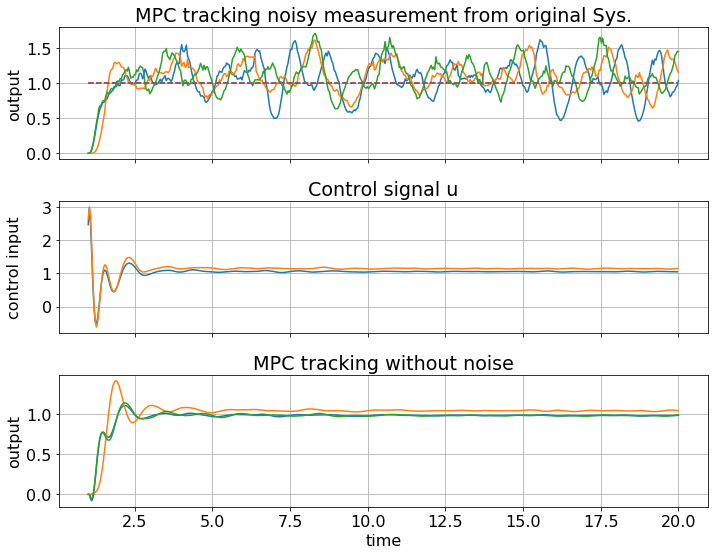

In [28]:
## results visualization ##
res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))

res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].plot(time,REFERENCE.T[:N_sim], '--')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
#ax[2].plot(time,REFERENCE.T[:N_sim], '--')
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Step_response',dpi=250)